#***STEP 1. Importing Libraries***

---



First, we import the necessary libraries for data handling, visualization, and forecasting.

In [ ]:
# Import necessary libraries
from prophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
# Ignore warnings
warnings.filterwarnings('ignore')


#***STEP 2. Defining Helper Functions***

---



We define functions for calculating MAPE and handling missing values.

In [ ]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 10

In [ ]:
# Function to handle missing values
def handle_missing_values(df, method='interpolate'):

    if method == 'interpolate':
        df = df.interpolate()

    return df

#***STEP 3. Forecasting Function***

---



We create a main function to load data, preprocess it, train a Prophet model, and forecast the next 5 years.





In [ ]:
# Main function to forecast the next 5 years
def forecast_next_5_years(data_path, class_name,missing_value_method='interpolate'):
    # Load the data
    data = pd.read_csv(data_path)

    # Preprocess the data
    to_drop = ['SubCounty', 'LogAmount', 'frequency', 'Year', 'PermitNo', 'ServiceHeaderID',
               'pin', 'CustomerName', 'ServiceName', 'IssuedBy', 'BusinessActivity',
               'Service Code', 'Ward', 'PhysicalLocation', 'DayOfWeek', 'Month', 'Column1']
    data.drop(to_drop, inplace=True, axis=1)

    # Filter the data for the specified class
    df = data[data['class'] == class_name].drop(columns='class')
    # Handle missing values
    df = handle_missing_values(df, method=missing_value_method)

    # Ensure DATE is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True).dt.strftime('%Y-%m-%d')
    df = df.groupby('DATE').mean().reset_index()
    df.set_index('DATE', inplace=True)
    df.sort_index(inplace=True)

    # Remove outliers
    Q1 = df['Amount'].quantile(0.25)
    Q3 = df['Amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    df = df.loc[(df['Amount'] > lower_lim) & (df['Amount'] < upper_lim)]

    # Plot the data
    color_pal = sns.color_palette()
    df.plot(style='.', figsize=(12, 5), ms=1, color=color_pal[0], title=f'{class_name} SBP')
    plt.show()

    # Split the data into training and test sets
    split_date = '2021-06-09'
    df_train = df.loc[df.index <= split_date].copy()
    df_test = df.loc[df.index > split_date].copy()

    # Prepare the data for Prophet
    df_train_prohet = df_train.reset_index().rename(columns={'DATE': 'ds', 'Amount': 'y'})
    df_test_prophet = df_test.reset_index().rename(columns={'DATE': 'ds', 'Amount': 'y'})
    df_test_prophet['ds'] = pd.to_datetime(df_test_prophet['ds'])

    # Train the Prophet model
    model = Prophet()
    model.fit(df_train_prohet)

    # Predict the test set
    df_test_fcst = model.predict(df_test_prophet)

    # Plot the predictions vs actual
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(df_test.index, df_test['Amount'], color='r', label='Actual')
    ax.plot(df_test.index, df_test_fcst['yhat'], color='b', label='Forecast')
    ax.set_title('Prophet Forecast vs Actual')
    ax.legend()
    plt.show()

    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_true=df_test['Amount'], y_pred=df_test_fcst['yhat']))
    mae = mean_absolute_error(y_true=df_test['Amount'], y_pred=df_test_fcst['yhat'])
    mape = mean_absolute_percentage_error(y_true=df_test['Amount'], y_pred=df_test_fcst['yhat'])
    accuracy = 100 - mape
    print(f'RMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}%\nAccuracy: {accuracy}%')

    # Forecast the next 5 years
    future = model.make_future_dataframe(periods=2400)
    forecast = model.predict(future)

    # Plot the forecasted values
    fig, ax = plt.subplots(figsize=(12, 5))
    fig = model.plot(forecast, ax=ax)
    ax.set_title(f'Prophet Forecast for the Next 5 Years ({class_name} SBP)')
    plt.show()

    # Plot the forecast components
    fig = model.plot_components(forecast)
    plt.show()

    # Display the forecasted values for the last few months of the forecast period
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())



#***STEP 4. Running the Forecast****

We call the function for different classes of data to forecast the next 5 years.

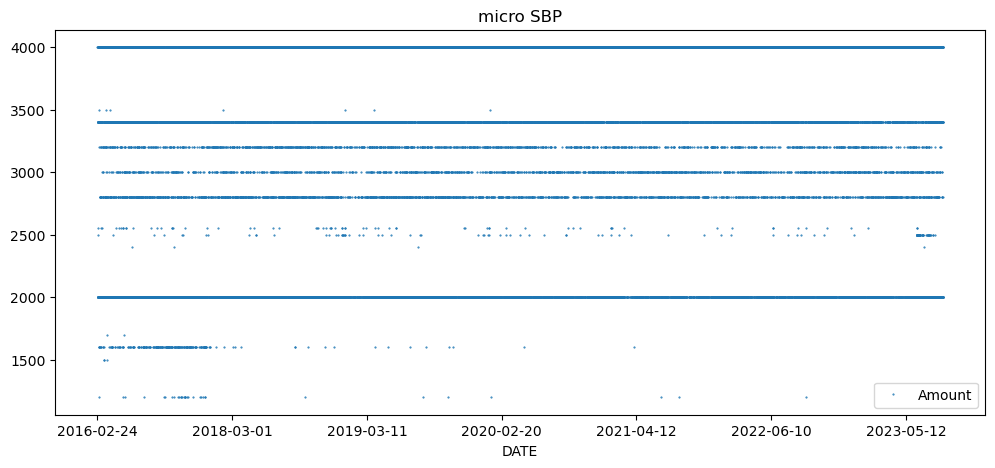

14:04:37 - cmdstanpy - INFO - Chain [1] start processing
14:04:49 - cmdstanpy - INFO - Chain [1] done processing


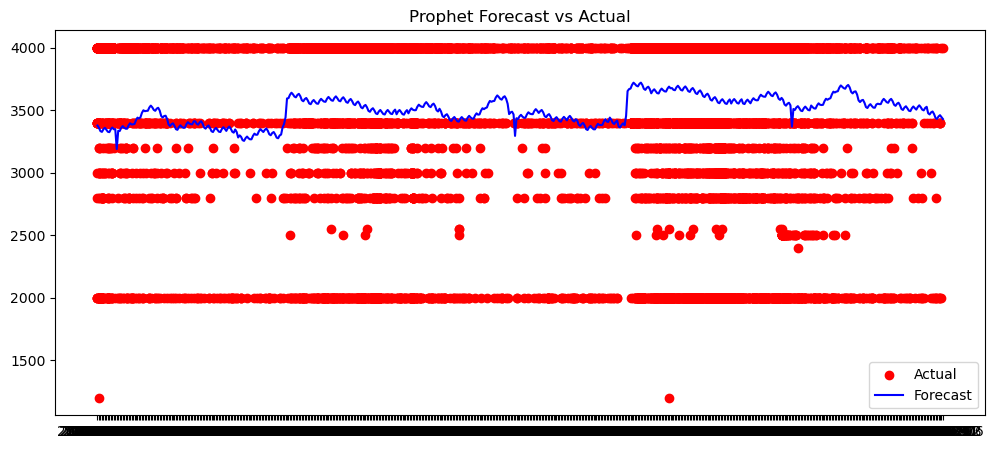

RMSE: 772.3777329027259
MAE: 617.6203594575553
MAPE: 2.3181567317619236%
Accuracy: 97.68184326823808%


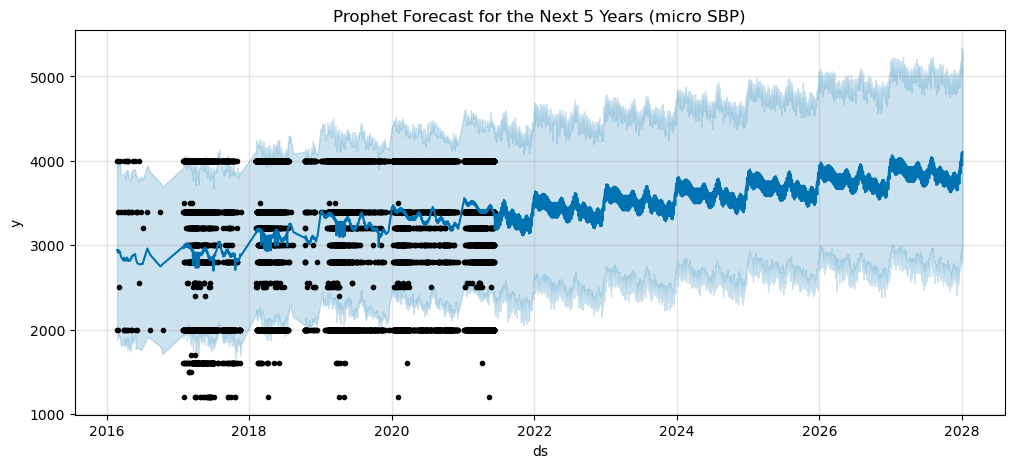

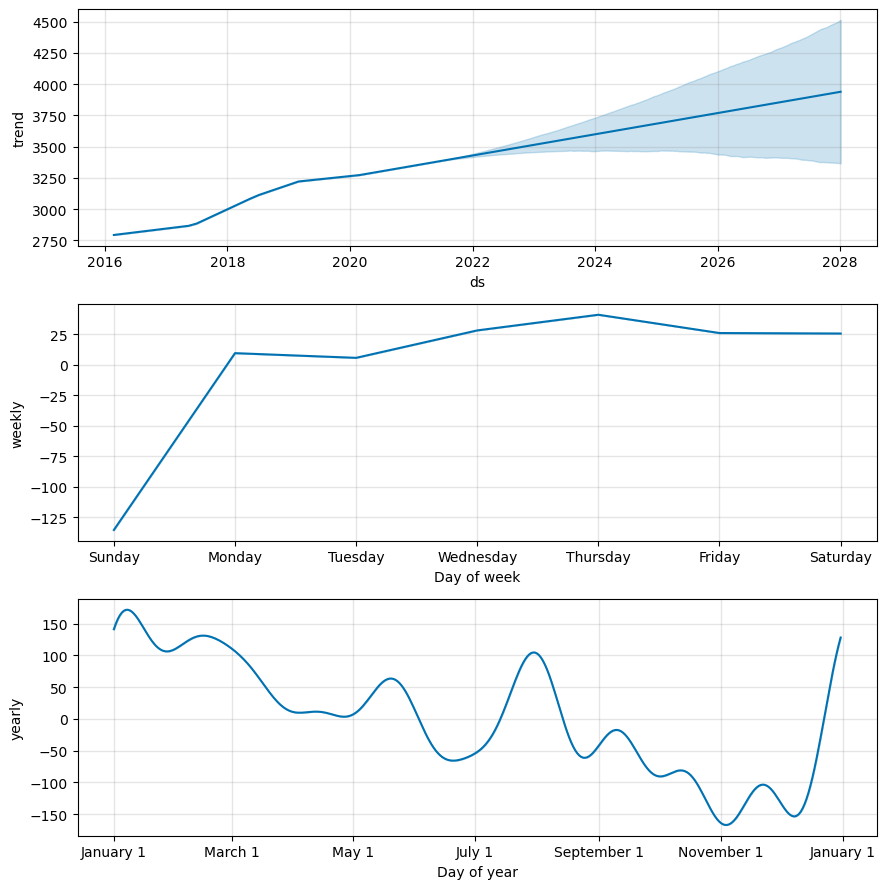

             ds         yhat   yhat_lower   yhat_upper
3398 2027-12-31  4085.742943  2936.117916  5346.364455
3399 2028-01-01  4096.875185  2876.418960  5277.754217
3400 2028-01-02  3946.069814  2800.775774  5012.190405
3401 2028-01-03  4099.553222  2850.261860  5320.420025
3402 2028-01-04  4102.858838  3017.550120  5268.723509


In [ ]:
# Forecast for 'micro' class
forecast_next_5_years('modified_working_data.csv', 'micro')


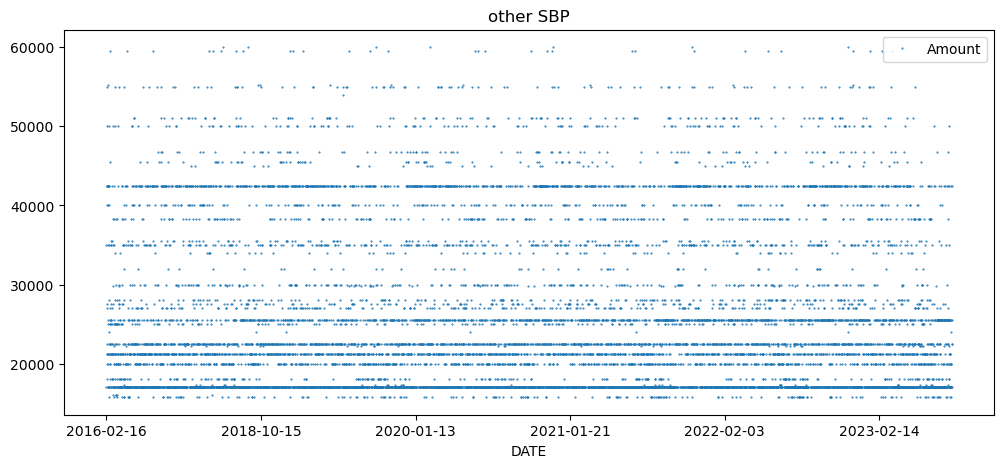

13:54:30 - cmdstanpy - INFO - Chain [1] start processing
13:54:32 - cmdstanpy - INFO - Chain [1] done processing


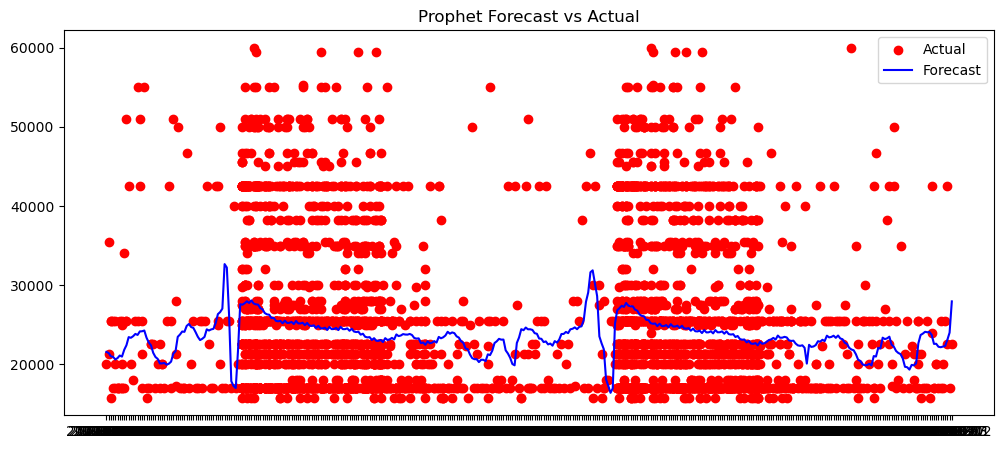

RMSE: 9574.00433116259
MAE: 7352.05129481134
MAPE: 2.857185170937893%
Accuracy: 97.1428148290621%


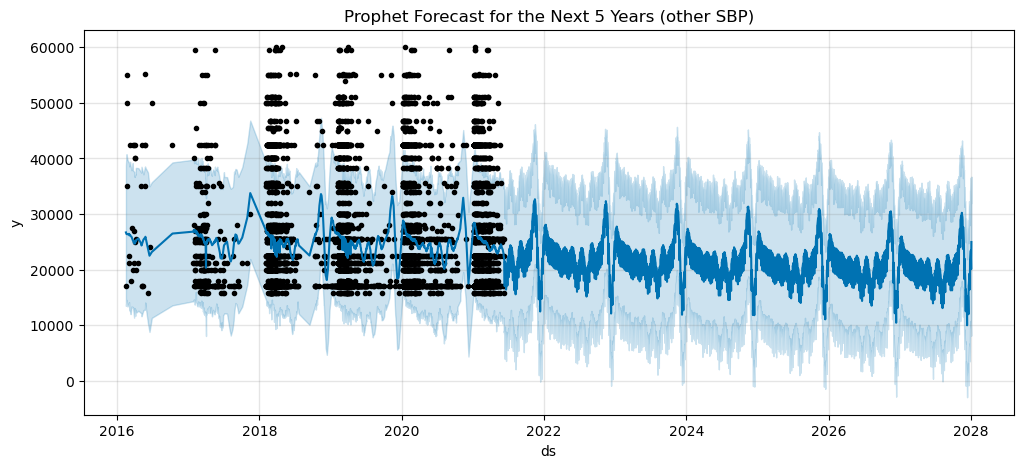

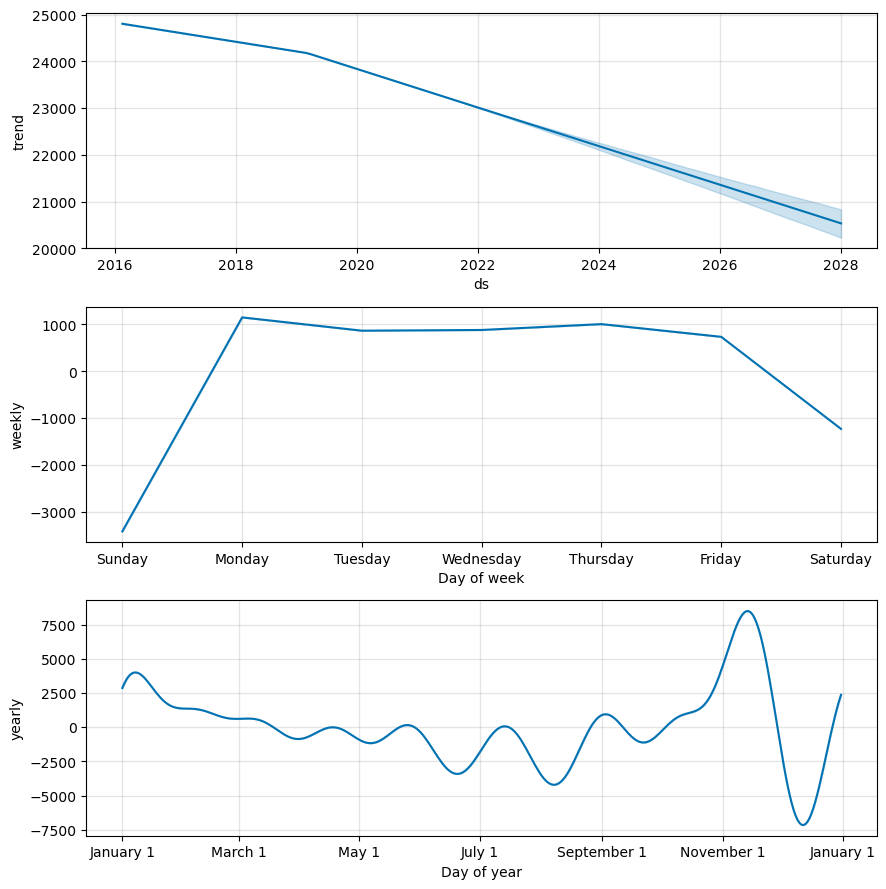

             ds          yhat    yhat_lower    yhat_upper
3102 2027-12-30  23209.416923  10774.102137  36542.717908
3103 2027-12-31  23421.228549  10121.122156  36440.218000
3104 2028-01-01  21885.873030   9277.362372  33860.416655
3105 2028-01-02  20072.588052   8111.665357  31923.229188
3106 2028-01-03  24958.303412  12500.585139  36715.674266


In [ ]:
# Forecast for 'other' class
forecast_next_5_years('modified_working_data.csv', 'other')


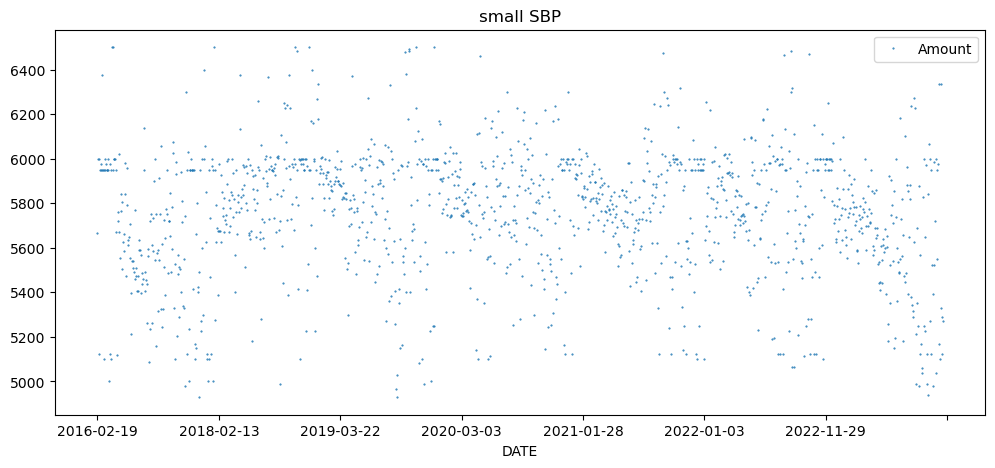

15:09:15 - cmdstanpy - INFO - Chain [1] start processing
15:09:16 - cmdstanpy - INFO - Chain [1] done processing


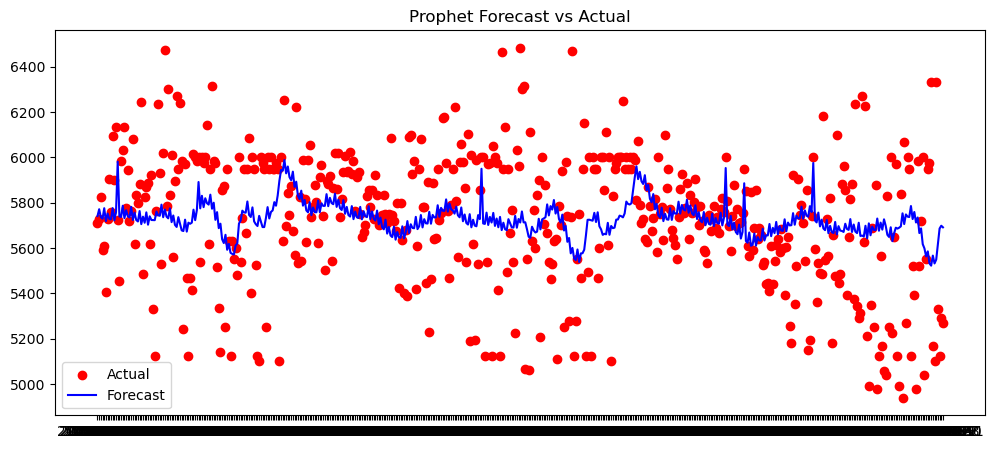

RMSE: 290.0666520245851
MAE: 226.34151370232925
MAPE: 0.40033197292425515%
Accuracy: 99.59966802707575%


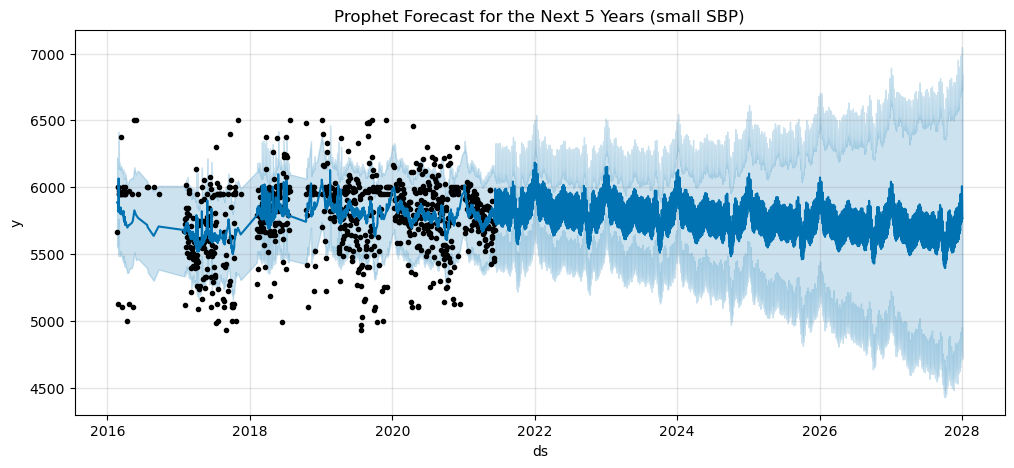

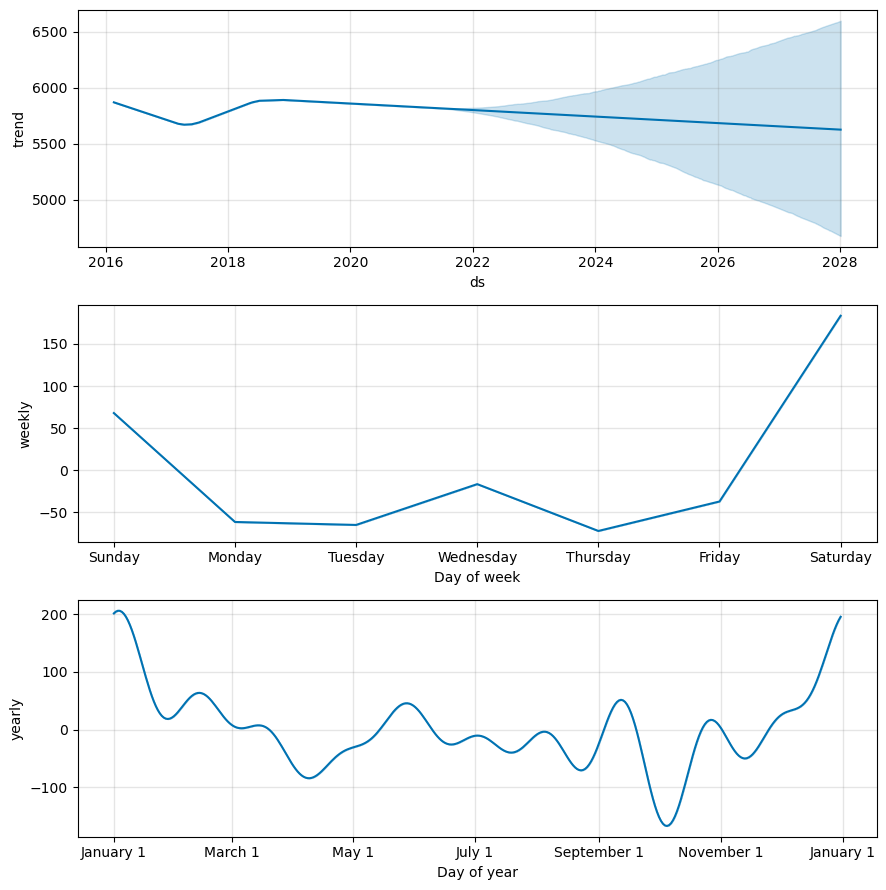

             ds         yhat   yhat_lower   yhat_upper
3286 2027-12-31  5781.153279  4749.783044  6861.315815
3287 2028-01-01  6007.005226  4953.978772  7047.297426
3288 2028-01-02  5895.668138  4836.318261  6882.099576
3289 2028-01-03  5769.039843  4716.951600  6732.550206
3290 2028-01-04  5766.545220  4766.654762  6841.645032


In [ ]:
# Forecast for 'small' class
forecast_next_5_years('modified_working_data.csv', 'small')


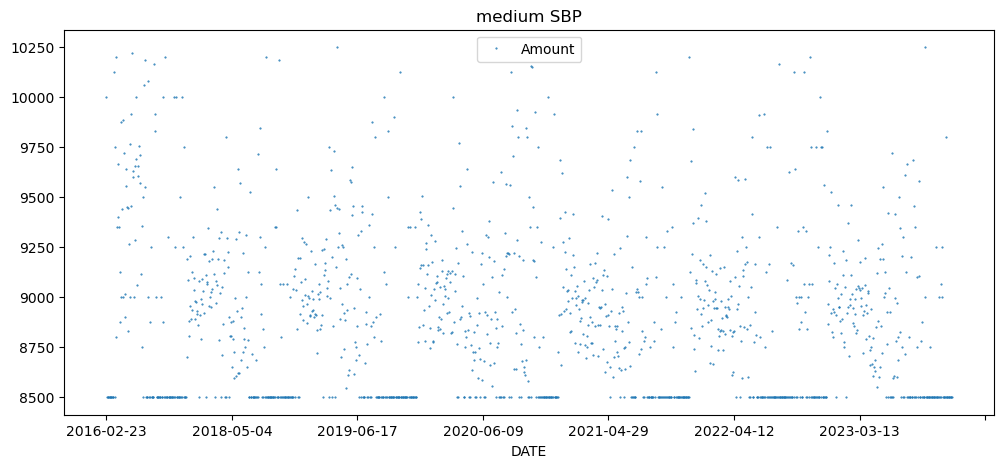

15:08:19 - cmdstanpy - INFO - Chain [1] start processing
15:08:20 - cmdstanpy - INFO - Chain [1] done processing


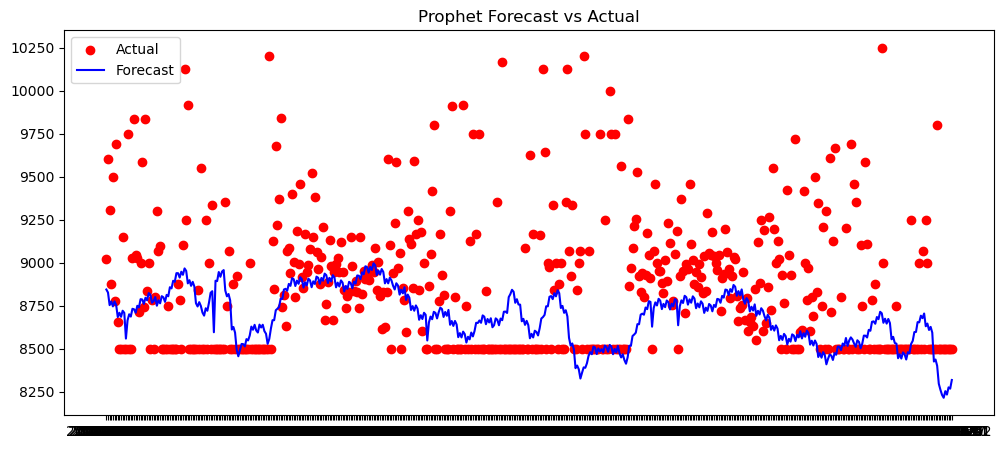

RMSE: 439.25785508677683
MAE: 300.31012368702886
MAPE: 0.32690506180861745%
Accuracy: 99.67309493819138%


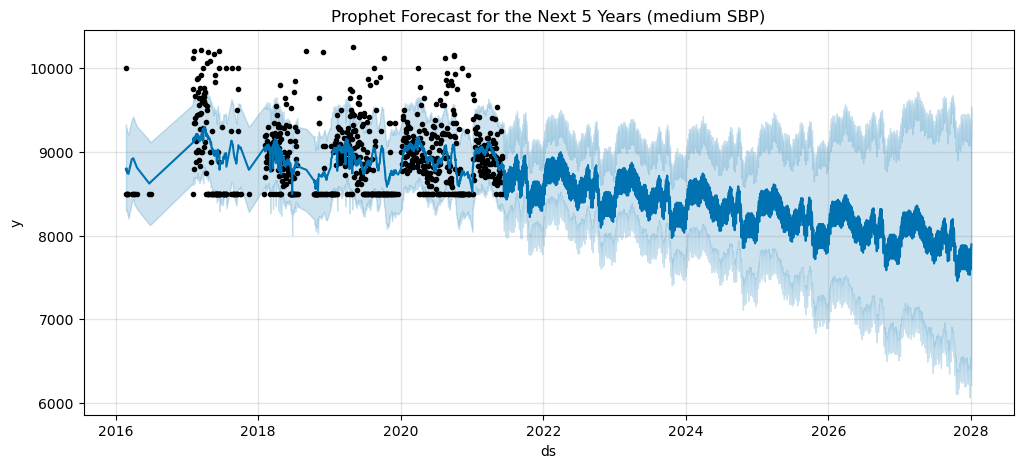

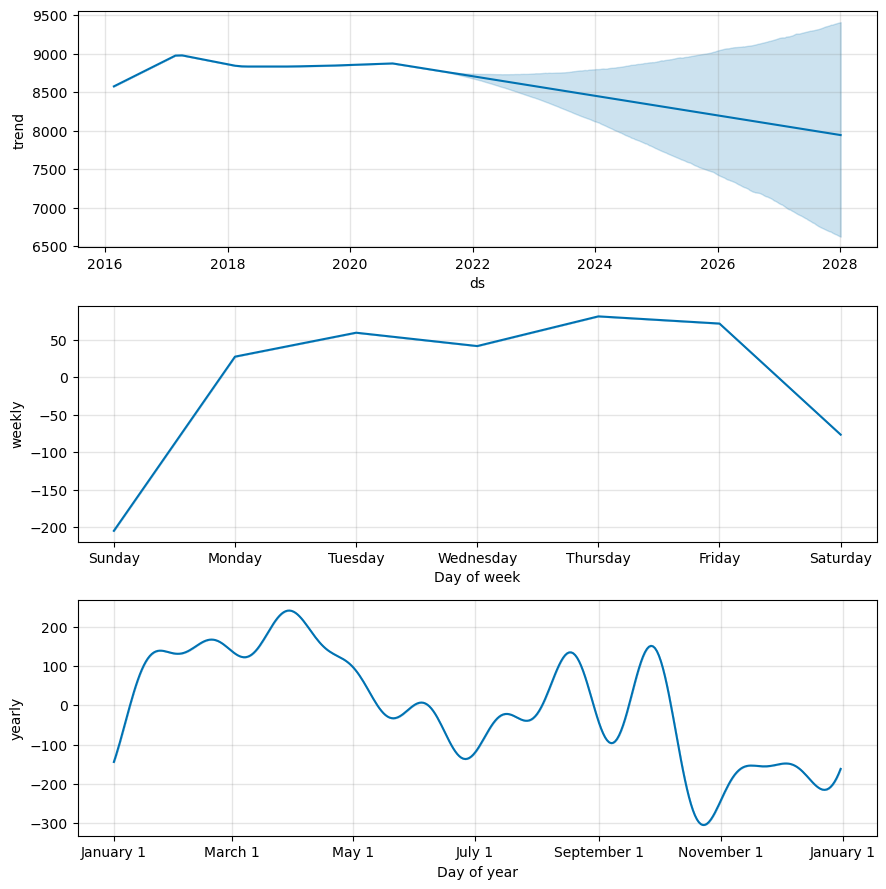

             ds         yhat   yhat_lower   yhat_upper
3223 2027-12-31  7846.664685  6457.328860  9393.552881
3224 2028-01-01  7711.187112  6347.863979  9262.508620
3225 2028-01-02  7596.940433  6209.226372  9170.557183
3226 2028-01-03  7845.078000  6409.583378  9537.505327
3227 2028-01-04  7893.576324  6555.730376  9440.485838


In [ ]:
# Forecast for 'medium' class with missing value handling
forecast_next_5_years('modified_working_data.csv','medium', missing_value_method='interpolate')
